<a href="https://colab.research.google.com/github/ab-sa/Statistical-Machine-Learning-2/blob/main/Lecture4_stagewise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
#import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
#!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools

Import Credit data

In [ ]:
Credit = pd.read_csv('Credit.csv')
Insurance = pd.read_csv('Insurance.csv')
print('Dimension of the data: ' + str(Credit.shape))
Credit.head()

Dimension of the data: (400, 12)


,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Dummy variabes for categorical predictors:

In [ ]:
Credit_dumms = pd.get_dummies(Credit)
Credit_dumms

,ID,Income,Limit,Rating,Cards,Age,Education,Balance,Gender_ Male,Gender_Female,Student_No,Student_Yes,Married_No,Married_Yes,Ethnicity_African American,Ethnicity_Asian,Ethnicity_Caucasian
0,1,14.891,3606,283,2,34,11,333,1,0,1,0,0,1,0,0,1
1,2,106.025,6645,483,3,82,15,903,0,1,0,1,0,1,0,1,0
2,3,104.593,7075,514,4,71,11,580,1,0,1,0,1,0,0,1,0
3,4,148.924,9504,681,3,36,11,964,0,1,1,0,1,0,0,1,0
4,5,55.882,4897,357,2,68,16,331,1,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,396,12.096,4100,307,3,32,13,560,1,0,1,0,0,1,0,0,1
396,397,13.364,3838,296,5,65,17,480,1,0,1,0,1,0,1,0,0
397,398,57.872,4171,321,5,67,12,138,0,1,1,0,0,1,0,0,1
398,399,37.728,2525,192,1,44,13,0,1,0,1,0,0,1,0,0,1


**Feature selection**

- Forward selection

In [ ]:
# Call multiple linear regression model
MLReg = LinearRegression()
sfs1 = sfs(MLReg, k_features=5, forward=True, verbose=2, scoring='neg_mean_squared_error')
sfs1 = sfs1.fit(Credit[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education']],
                Credit['Balance'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s finished

[2021-12-09 03:56:52] Features: 1/5 -- score: -54293.17658429352[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished

[2021-12-09 03:56:52] Features: 2/5 -- score: -26775.95426714271[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2021-12-09 03:56:52] Features: 3/5 -- score: -26555.743240985805[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1

Names of the features selected by forward selection algorithm in a model of size 4:

In [ ]:
list(sfs1.k_feature_names_)

['Income', 'Limit', 'Rating', 'Age', 'Education']

**Best subset selection**

Need to defile two new functions in order to get the best subset model of varies sizes:

*(Credit to: http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html)*

In [ ]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

After defining y and X, with a for loop, you can get the best subset of multiple linear regression models of different sizes:

In [ ]:
X = Credit_dumms.loc[:, Credit_dumms.columns != 'Balance']
y = Credit_dumms['Balance']

models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,10):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")


Processed 16 models on 1 predictors in 0.05578494071960449 seconds.
Processed 120 models on 2 predictors in 0.3693852424621582 seconds.
Processed 560 models on 3 predictors in 1.70253586769104 seconds.
Processed 1820 models on 4 predictors in 5.763361215591431 seconds.
Processed 4368 models on 5 predictors in 13.893580436706543 seconds.
Processed 8008 models on 6 predictors in 25.82901120185852 seconds.
Processed 11440 models on 7 predictors in 38.04533791542053 seconds.
Processed 12870 models on 8 predictors in 43.996201515197754 seconds.
Processed 11440 models on 9 predictors in 57.976975202560425 seconds.
Total elapsed time: 188.73053359985352 seconds.


RSS of the best subset models:

In [ ]:
models_best

,RSS,model
1,2.828499e+07,<statsmodels.regression.linear_model.Regressio...
2,1.572713e+07,<statsmodels.regression.linear_model.Regressio...
3,4.317784e+06,<statsmodels.regression.linear_model.Regressio...
4,4.021249e+06,<statsmodels.regression.linear_model.Regressio...
5,3.893105e+06,<statsmodels.regression.linear_model.Regressio...
6,3.865872e+06,<statsmodels.regression.linear_model.Regressio...
7,3.821620e+06,<statsmodels.regression.linear_model.Regressio...
8,3.810759e+06,<statsmodels.regression.linear_model.Regressio...
9,3.800969e+06,<statsmodels.regression.linear_model.Regressio...


R-squared of best subset models of different sizes:

In [ ]:
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.853070
2    0.918303
3    0.977571
4    0.979111
5    0.979777
6    0.979918
7    0.954688
8    0.954817
9    0.954933
dtype: float64

Summary of the best subset model of size 3:

In [ ]:
print(models_best.loc[3, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                Balance   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              5768.
Date:                Thu, 09 Dec 2021   Prob (F-statistic):                        0.00
Time:                        04:05:57   Log-Likelihood:                         -2424.9
No. Observations:                 400   AIC:                                      4856.
Df Residuals:                     397   BIC:                                      4868.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Visualization of best subset models performance:

Text(0, 0.5, 'BIC')

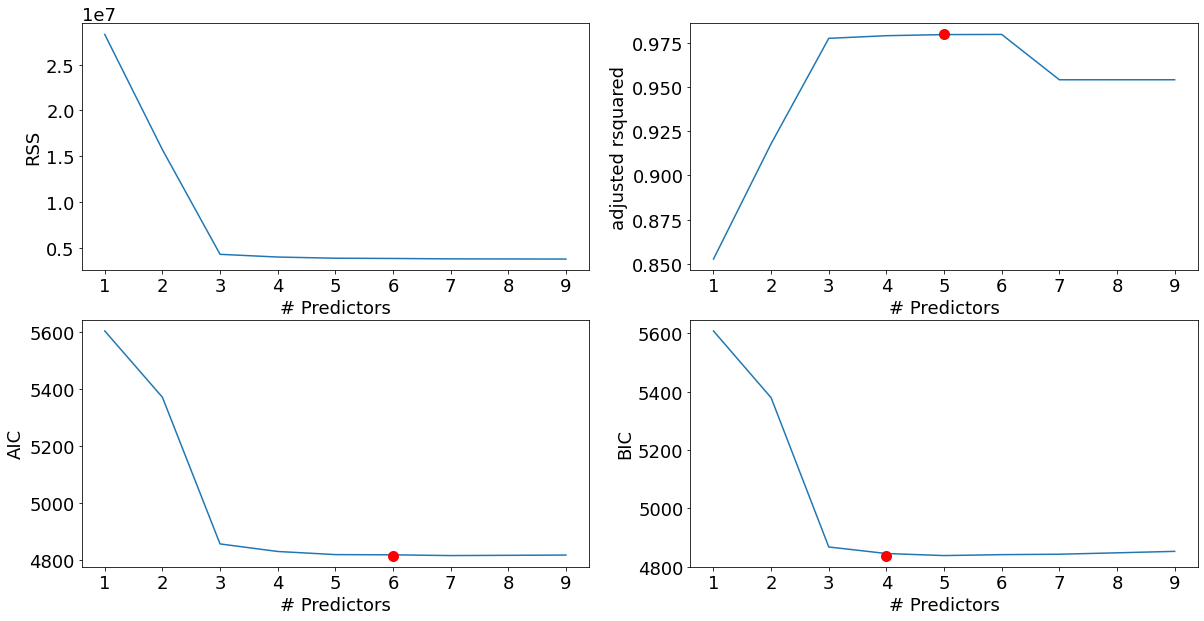

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')